In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'Der Tagesspiegel',
    'ARD',
    'tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'ZEIT ONLINE',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

search_terms = {
    'cdu':['cdu', 'union'],
    'csu':['csu', 'union'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [55]:
def extract_party_mentions(input_string, party_strings, n_words=10):
    input_string = input_string.lower()
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        temp = [string.__contains__(p) for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    output_strings = ['' for _ in range(len(party_index))]
    for i in range(len(party_index)):
        lower_bound = party_index[i]-n_words
        upper_bound = party_index[i]+n_words
        if lower_bound < 0:
            lower_bound = 0
        if upper_bound > len(input_string.split()):
            upper_bound = len(input_string.split())
        output_strings[i] = " ".join(input_string.split()[lower_bound:upper_bound])
    return output_strings

def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

def extract_avg_sentiment_df(input_df):
    avg_pos = input_df[input_df['positive']].groupby(['medium'])['score'].median()
    avg_neu = input_df[input_df['neutral']].groupby(['medium'])['score'].median()
    avg_neg = input_df[input_df['negative']].groupby(['medium'])['score'].median()
    output_df = pd.DataFrame(data={'avg_pos':avg_pos, 'avg_neu':avg_neu, 'avg_neg':avg_neg})
    return output_df

def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

def get_avg_party_sentiment(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_avg_sentiment_df(df)
    return df['avg_pos'], df['avg_neu'], df['avg_neg']

def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

def standardize_df(input_df):
    df = input_df.copy()
    for party in search_terms.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [56]:
df = pd.read_pickle('../data/topics_combined.pkl')
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)

tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
scaler = StandardScaler()

In [57]:
ind = 2
party = 'spd'
n_words = 20

subset = 'contains_' + party
teststring = df.loc[df[subset]].iloc[ind]['transcript']
extracted_strings = extract_party_mentions(input_string=teststring, party_strings=search_terms[party], n_words=n_words)
print(f'Strings: {extracted_strings}')
print(f'Classification: {classifier(extracted_strings)}')

Strings: ['rausgegangen. es dauerte, glaube ich, doch einige jahre, bis sich die partei und nicht nur die grünen, sondern auch die spd, davon wieder erholt haben. glauben sie, das könnte ihnen wieder passieren? insbesondere, wenn wie von frau reemtsma deutlich gemacht,']
Classification: [{'label': 'negative', 'score': 0.7712906002998352}]


In [58]:
'''pos_dict = {}
neu_dict = {}
neg_dict = {}
for party in search_terms.keys():
    pos_dict[party], neu_dict[party], neg_dict[party] = get_avg_party_sentiment(party)

pos_df = pd.DataFrame(pos_dict)
pos_df = pos_df.loc[media]
pos_df = pos_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neu_df = pd.DataFrame(neu_dict)
neu_df = neu_df.loc[media]
neu_df = neu_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neg_df = pd.DataFrame(neg_dict)
neg_df = neg_df.loc[media]
neg_df = neg_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

pos_df.to_pickle('../assets/pos_df.pkl')
neu_df.to_pickle('../assets/neu_df.pkl')
neg_df.to_pickle('../assets/neg_df.pkl')'''

"pos_dict = {}\nneu_dict = {}\nneg_dict = {}\nfor party in search_terms.keys():\n    pos_dict[party], neu_dict[party], neg_dict[party] = get_avg_party_sentiment(party)\n\npos_df = pd.DataFrame(pos_dict)\npos_df = pos_df.loc[media]\npos_df = pos_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\nneu_df = pd.DataFrame(neu_dict)\nneu_df = neu_df.loc[media]\nneu_df = neu_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\nneg_df = pd.DataFrame(neg_dict)\nneg_df = neg_df.loc[media]\nneg_df = neg_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\n\npos_df.to_pickle('../assets/pos_df.pkl')\nneu_df.to_pickle('../assets/neu_df.pkl')\nneg_df.to_pickle('../assets/neg_df.pkl')"

In [59]:
pos_df = pd.read_pickle('../assets/pos_df.pkl')
neu_df = pd.read_pickle('../assets/neu_df.pkl')
neg_df = pd.read_pickle('../assets/neg_df.pkl')

In [60]:
'''f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos_df, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='median positive sentiment polarity by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu_df, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='median neutral sentiment polarity by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg_df, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='median negative sentiment polarity by medium and party')'''

'f, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(pos_df, annot=True, fmt=".2", linewidths=.5, ax=ax)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'median positive sentiment polarity by medium and party\')\n\nf, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(neu_df, annot=True, fmt=".2", linewidths=.5, ax=ax)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'median neutral sentiment polarity by medium and party\')\n\nf, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(neg_df, annot=True, fmt=".2", linewidths=.5, ax=ax)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'median negative sentiment polarity by medium and party\')'

In [61]:
'''pos_counts_dict = {}
neu_counts_dict = {}
neg_counts_dict = {}
for party in search_terms.keys():
    pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

pos_counts_df = pd.DataFrame(pos_counts_dict)
pos_counts_df = pos_counts_df.loc[media]
pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neu_counts_df = pd.DataFrame(neu_counts_dict)
neu_counts_df = neu_counts_df.loc[media]
neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neg_counts_df = pd.DataFrame(neg_counts_dict)
neg_counts_df = neg_counts_df.loc[media]
neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

pos_counts_df.to_pickle('../assets/pos_counts_df.pkl')
neu_counts_df.to_pickle('../assets/neu_counts_df.pkl')
neg_counts_df.to_pickle('../assets/neg_counts_df.pkl')'''

"pos_counts_dict = {}\nneu_counts_dict = {}\nneg_counts_dict = {}\nfor party in search_terms.keys():\n    pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)\n\npos_counts_df = pd.DataFrame(pos_counts_dict)\npos_counts_df = pos_counts_df.loc[media]\npos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\nneu_counts_df = pd.DataFrame(neu_counts_dict)\nneu_counts_df = neu_counts_df.loc[media]\nneu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\nneg_counts_df = pd.DataFrame(neg_counts_dict)\nneg_counts_df = neg_counts_df.loc[media]\nneg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\n\npos_counts_df.to_pickle('../assets/pos_counts_df.pkl')\nneu_counts_df.to_pickle('../assets/neu_counts_df.pkl')\nneg_counts_df.to_pickle('../assets/neg_counts_df.pkl')"

In [62]:
pos_counts_df = pd.read_pickle('../assets/pos_counts_df.pkl')
neu_counts_df = pd.read_pickle('../assets/neu_counts_df.pkl')
neg_counts_df = pd.read_pickle('../assets/neg_counts_df.pkl')

In [63]:
'''sent_df = (pos_counts_df - neg_counts_df).transpose()
scaler = StandardScaler()
scaled_sent_df = pd.DataFrame(data=scaler.fit_transform(sent_df), columns=sent_df.columns, index=sent_df.index).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(scaled_sent_df, annot=True, linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='sentiment counts by medium and party, standard scaler\n(number of positive mentions - number of negative mentions)')

pos_sent_df = pos_counts_df.transpose()
scaler = StandardScaler()
scaled_pos_sent_df = pd.DataFrame(data=scaler.fit_transform(pos_sent_df), columns=pos_sent_df.columns, index=pos_sent_df.index).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(scaled_pos_sent_df, annot=True, linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='positive sentiment counts by medium and party, standard scaler')

neg_sent_df = neg_counts_df.transpose()
scaler = StandardScaler()
scaled_neg_sent_df = pd.DataFrame(data=scaler.fit_transform(neg_sent_df), columns=neg_sent_df.columns, index=neg_sent_df.index).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(scaled_neg_sent_df, annot=True, linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='negative sentiment counts by medium and party, standard scaler')'''

"sent_df = (pos_counts_df - neg_counts_df).transpose()\nscaler = StandardScaler()\nscaled_sent_df = pd.DataFrame(data=scaler.fit_transform(sent_df), columns=sent_df.columns, index=sent_df.index).transpose()\nf, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(scaled_sent_df, annot=True, linewidths=.5, ax=ax)\nax.set(xlabel='party', ylabel='medium', title='sentiment counts by medium and party, standard scaler\n(number of positive mentions - number of negative mentions)')\n\npos_sent_df = pos_counts_df.transpose()\nscaler = StandardScaler()\nscaled_pos_sent_df = pd.DataFrame(data=scaler.fit_transform(pos_sent_df), columns=pos_sent_df.columns, index=pos_sent_df.index).transpose()\nf, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(scaled_pos_sent_df, annot=True, linewidths=.5, ax=ax)\nax.set(xlabel='party', ylabel='medium', title='positive sentiment counts by medium and party, standard scaler')\n\nneg_sent_df = neg_counts_df.transpose()\nscaler = StandardScaler()\nscaled_neg_sent_df = pd.Dat

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'positive sentiment proportions by medium and party, standardized')]

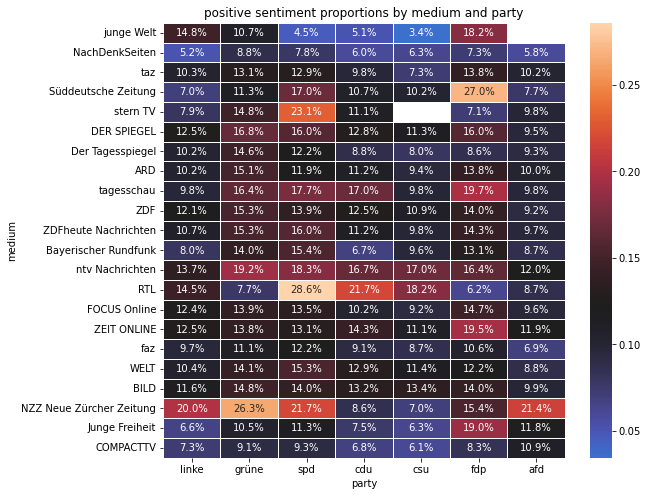

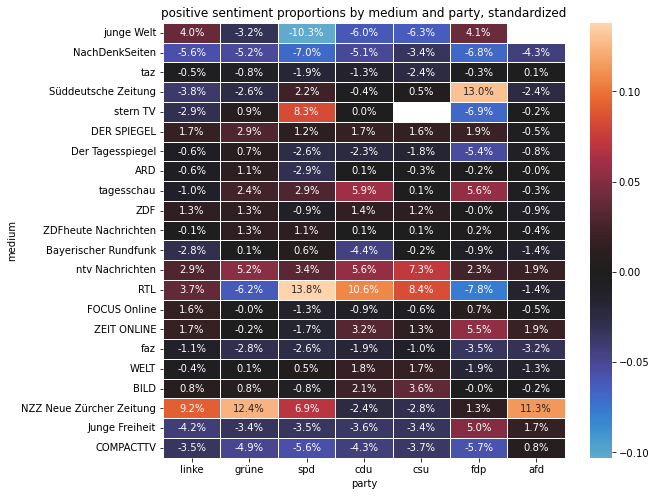

In [75]:
pos = pos_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        pos.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(pos))
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)))
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party, standardized')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'neutral sentiment proportions by medium and party, standardized')]

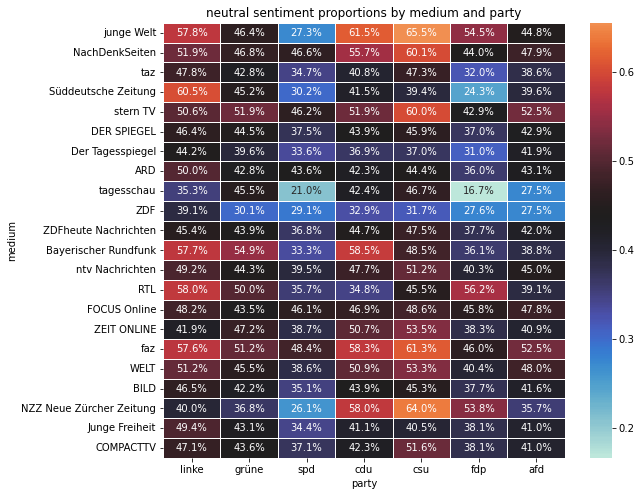

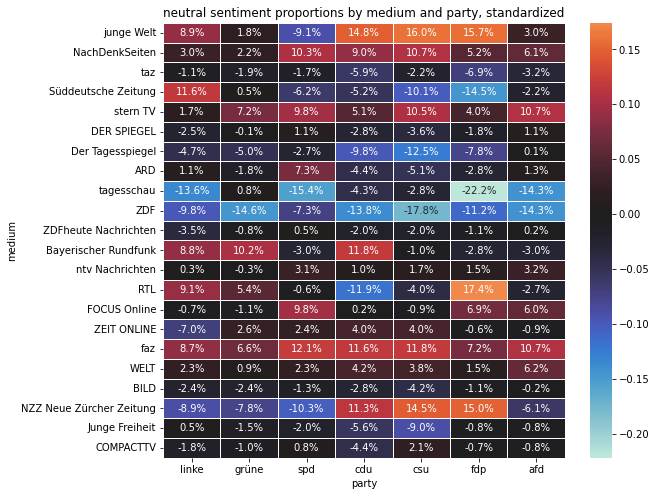

In [74]:
neu = neu_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neu.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neu))
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)))
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party, standardized')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'negative sentiment proportions by medium and party, standardized')]

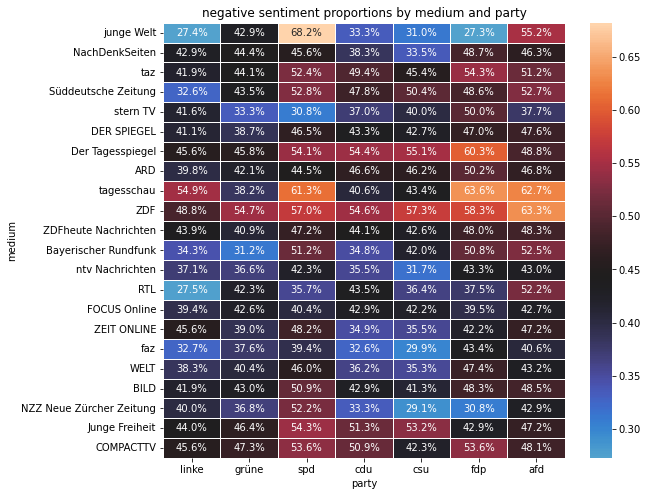

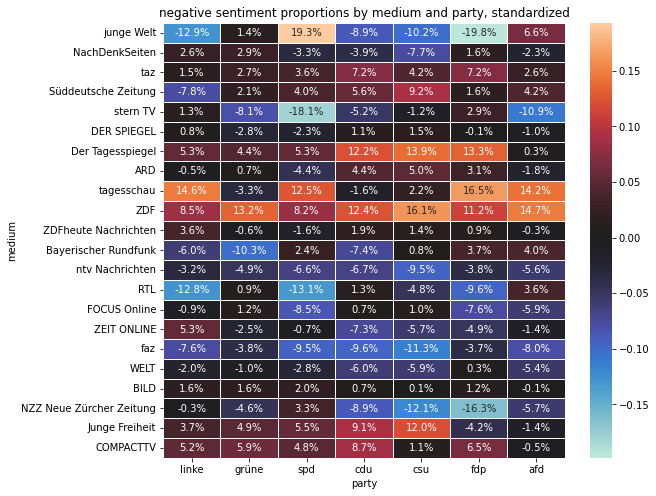

In [73]:
neg = neg_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neg.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neg))
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)))
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party, standardized')